In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load data
data = pd.read_csv("/content/district wise population and centroids.csv")

# Feature Engineering
data['Population Growth'] = data['Population in 2011'] - data['Population in 2001']

# Encode categorical variables
data = pd.get_dummies(data, columns=['State', 'District'])

# Define features and target
X = data.drop(['Population in 2011', 'Population Growth'], axis=1)
y = data['Population in 2011']  # Or use 'Population Growth'

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")


Mean Squared Error: 21985415432.574665
R2 Score: 0.9847255108397756


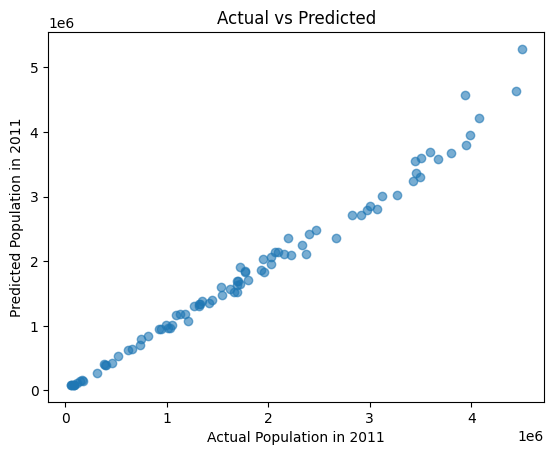

In [6]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Actual Population in 2011")
plt.ylabel("Predicted Population in 2011")
plt.title("Actual vs Predicted")
plt.show()


In [11]:
import pandas as pd
import folium
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from folium.plugins import HeatMap

# Load the dataset
data = pd.read_csv("/content/district wise population and centroids.csv")

# Ensure data contains required columns
required_columns = ['State', 'District', 'Latitude', 'Longitude', 'Population in 2001', 'Population in 2011']
for col in required_columns:
    if col not in data.columns:
        raise ValueError(f"Missing required column: {col}")

# Prepare data for regression
X = data[['Population in 2001']]  # Feature(s)
y = data['Population in 2011']    # Target variable

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Add a column to the dataset indicating train/test rows
data['Set'] = 'Train'
data.loc[X_test.index, 'Set'] = 'Test'

# Add predictions to the test rows
data['Predicted Population 2011'] = None
data.loc[X_test.index, 'Predicted Population 2011'] = y_pred

# Handle NaN predictions (if any)
data['Predicted Population 2011'] = data['Predicted Population 2011'].fillna(0)

# Create a base map centered on the data's mean latitude and longitude
map_center = [data['Latitude'].mean(), data['Longitude'].mean()]
pop_map = folium.Map(location=map_center, zoom_start=5)

# Add points to the map for rows with predictions (test data)
test_data = data[data['Set'] == 'Test']
for index, row in test_data.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=row['Predicted Population 2011'] / 1e6,  # Adjust radius scale
        popup=folium.Popup(f"District: {row['District']}<br>"
                           f"State: {row['State']}<br>"
                           f"Predicted Population: {row['Predicted Population 2011']:.2f}"),
        color='blue',
        fill=True,
        fill_color='cyan',
        fill_opacity=0.6
    ).add_to(pop_map)

# Add a HeatMap for Population Growth
data['Population Growth'] = data['Population in 2011'] - data['Population in 2001']
heat_data = [[row['Latitude'], row['Longitude'], row['Population Growth']] for index, row in data.iterrows()]
HeatMap(heat_data).add_to(pop_map)

# Save the map to an HTML file
pop_map.save("population_map.html")

# Display a success message
print("Map created and saved as 'population_map.html'. Open it in a browser to view.")


<ipython-input-11-74aa26559d66>:39: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Predicted Population 2011'] = data['Predicted Population 2011'].fillna(0)


Map created and saved as 'population_map.html'. Open it in a browser to view.


/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Do

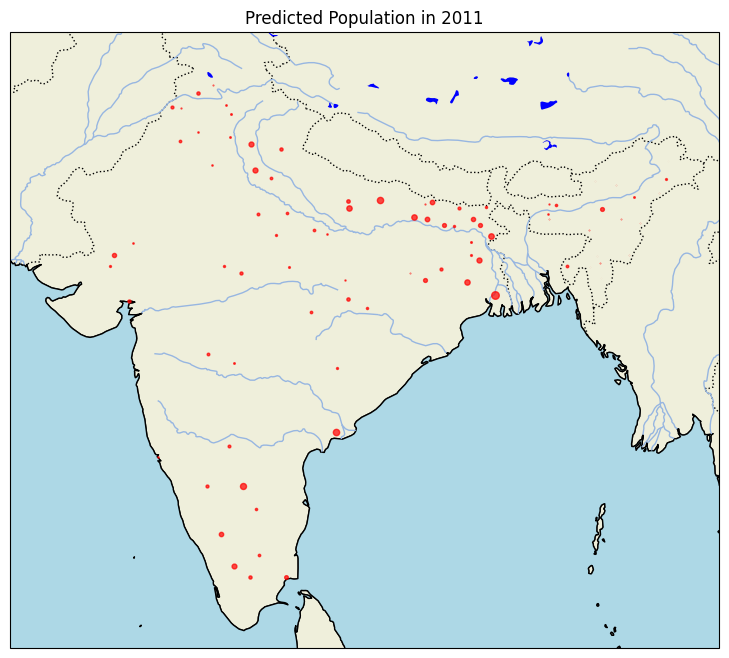

In [16]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Prepare data
lats = data['Latitude']
lons = data['Longitude']
predicted = data['Predicted Population 2011']

# Create the map
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.LAKES, facecolor='blue')
ax.add_feature(cfeature.RIVERS)

# Plot points
for lat, lon, pred in zip(lats, lons, predicted):
    if not pd.isnull(pred):  # Skip missing predictions
        size = pred / 1e6  # Adjust circle size
        ax.plot(lon, lat, 'o', markersize=size, color='red', alpha=0.7, transform=ccrs.PlateCarree())

# Add title
plt.title("Predicted Population in 2011")
plt.show()


In [15]:
!pip install cartopy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 26.1 MB/s eta 0:00:00


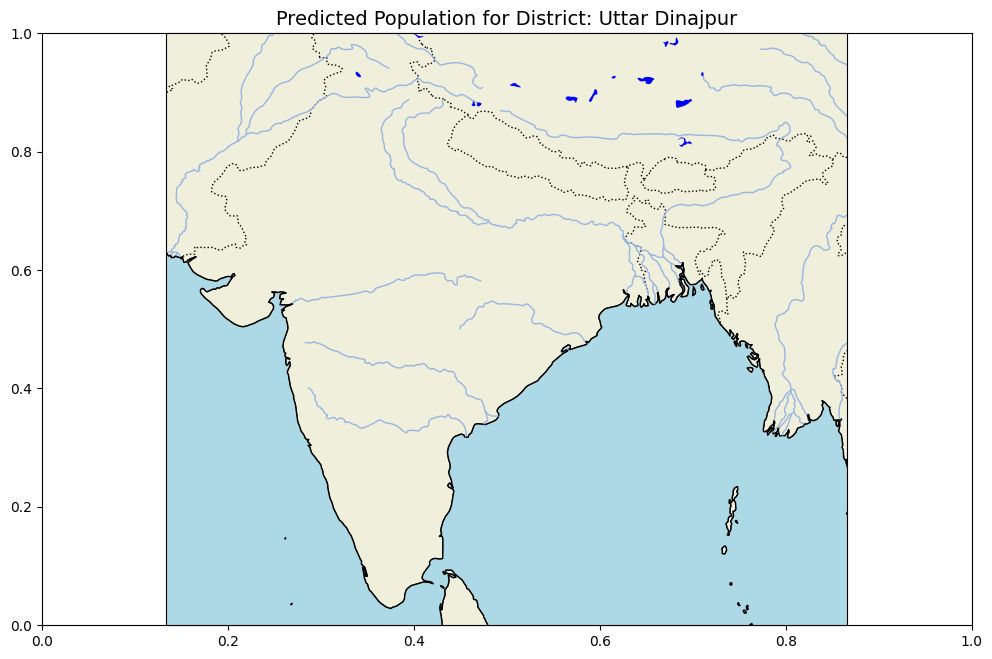

In [22]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.animation import FuncAnimation

# Prepare data
lats = data['Latitude']
lons = data['Longitude']
predicted = data['Predicted Population 2011']

# Create the map
fig, ax = plt.subplots(figsize=(12, 8))

# Set the map projection (PlateCarree is a simple rectangular projection)
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.LAKES, facecolor='blue')
ax.add_feature(cfeature.RIVERS)

# Adjust layout to avoid overlapping of title and map
plt.subplots_adjust(top=0.85)

scatter = None

def update(frame):
    global scatter
    if scatter:
        scatter.remove()

    # Get the coordinates and population prediction for the current frame
    lat, lon, pop = lats.iloc[frame], lons.iloc[frame], predicted.iloc[frame]

    # Increase marker size by a factor and make the color more bold
    marker_size = pop / 1e4  # Adjust the scaling for the marker size
    scatter = ax.scatter(lon, lat, s=marker_size, color='red', alpha=0.9, edgecolor='black', linewidth=1, transform=ccrs.PlateCarree())

    # Set the title dynamically to show the district name
    ax.set_title(f"Predicted Population for District: {data['District'].iloc[frame]}", fontsize=14)

# Create an animation that updates for each frame
ani = FuncAnimation(fig, update, frames=len(data), repeat=False)

# Save the animation as a video
ani.save("population_animation.mp4", writer='ffmpeg')

# Show the animation (optional in Jupyter Notebooks)
plt.show()
